In [141]:
import torch
from torch import nn, optim
import torch_directml
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
print(torch.__version__)
print(torchvision.__version__)
if torch_directml.is_available():
    device = torch_directml.device()
else:
    device = torch.device("cpu")
print(device)

2.4.1+cpu
0.19.1+cpu
privateuseone:0


In [142]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
def train_vs_test_loss(train_losses, test_losses):
    # Create epoch arrays for proper plotting
    epochs = list(range(len(train_losses)))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size": 14})

class ModelPath():
    def __init__(self):
        self.MODEL_PATH = Path("models")
        self.MODEL_PATH.mkdir(parents=True, exist_ok=True)
        self.MODEL_NAME = "01_pytorch_linear_regression_model.pth"
        self.MODEL_SAVE_PATH = self.MODEL_PATH / self.MODEL_NAME
        self.MODEL_SAVE_PATH
    
    def load(self, model:torch.nn.Module):
        model.load_state_dict(torch.load(self.MODEL_SAVE_PATH))
        print(f"Model loaded from {self.MODEL_SAVE_PATH}")

    def save(self, model:torch.nn.Module):
        torch.save(model.state_dict(), self.MODEL_SAVE_PATH)
        print(f"Model saved to {self.MODEL_SAVE_PATH}")


    



In [143]:
n_samples = 1000
X, y = make_circles(n_samples,
                     noise=0.03,
                     random_state=42,)


In [144]:
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


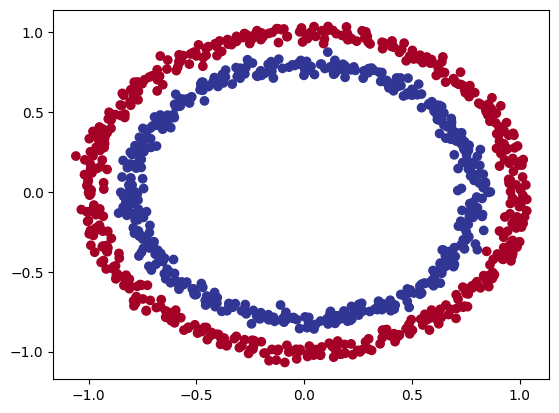

In [145]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [146]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [147]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(2, 8)
        self.h2 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.h1(x))
        x = self.h2(x)
        return x
    
model0_gpu = model().to(device)
model0_cpu = model().to("cpu")

In [149]:
loss_fn = nn.BCEWithLogitsLoss()  # Handles sigmoid internally
optimizer_gpu = torch.optim.SGD(model0_gpu.parameters(), lr=0.1)
optimizer_cpu = torch.optim.SGD(model0_cpu.parameters(), lr=0.1)

In [150]:
next(model0_gpu.parameters()).device, next(model0_cpu.parameters()).device


(device(type='privateuseone', index=0), device(type='cpu'))

In [151]:
torch.manual_seed(42)
X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [152]:
epochs_gpu = 0
train_losses_gpu = []
test_losses_gpu = []
epochs_cpu = 0
train_losses_cpu = []
test_losses_cpu = []

In [153]:
for _ in range(5500):
    model0_gpu.train()
    y_logits = model0_gpu(X_train_gpu).squeeze()
    loss = loss_fn(y_logits, y_train_gpu)
    y_pred = torch.round(torch.sigmoid(y_logits))
    acc = accuracy_fn(y_train_gpu, y_pred)

    optimizer_gpu.zero_grad()
    loss.backward()
    optimizer_gpu.step()

    train_losses_gpu.append(loss.item())
    model0_gpu.eval()
    with torch.no_grad():
        test_logits = model0_gpu(X_test_gpu).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test_gpu)
        test_acc = accuracy_fn(y_test_gpu, test_pred)
    
    test_losses_gpu.append(test_loss.item())
    epochs_gpu += 1
    print(f"Epoch: {epochs_gpu} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 1 | Loss: 0.69735, Acc: 48.75% | Test Loss: 0.69029, Test Acc: 53.00%
Epoch: 2 | Loss: 0.69687, Acc: 48.50% | Test Loss: 0.68990, Test Acc: 53.00%
Epoch: 3 | Loss: 0.69644, Acc: 49.12% | Test Loss: 0.68954, Test Acc: 53.00%
Epoch: 4 | Loss: 0.69604, Acc: 49.12% | Test Loss: 0.68922, Test Acc: 53.00%
Epoch: 5 | Loss: 0.69568, Acc: 49.12% | Test Loss: 0.68894, Test Acc: 53.00%
Epoch: 6 | Loss: 0.69534, Acc: 49.12% | Test Loss: 0.68867, Test Acc: 53.50%
Epoch: 7 | Loss: 0.69504, Acc: 49.38% | Test Loss: 0.68844, Test Acc: 54.00%
Epoch: 8 | Loss: 0.69476, Acc: 49.38% | Test Loss: 0.68822, Test Acc: 55.00%
Epoch: 9 | Loss: 0.69450, Acc: 49.25% | Test Loss: 0.68803, Test Acc: 55.00%
Epoch: 10 | Loss: 0.69426, Acc: 49.12% | Test Loss: 0.68785, Test Acc: 55.00%
Epoch: 11 | Loss: 0.69404, Acc: 48.75% | Test Loss: 0.68769, Test Acc: 55.50%
Epoch: 12 | Loss: 0.69384, Acc: 48.88% | Test Loss: 0.68754, Test Acc: 55.00%
Epoch: 13 | Loss: 0.69365, Acc: 48.75% | Test Loss: 0.68740, Test Acc: 54

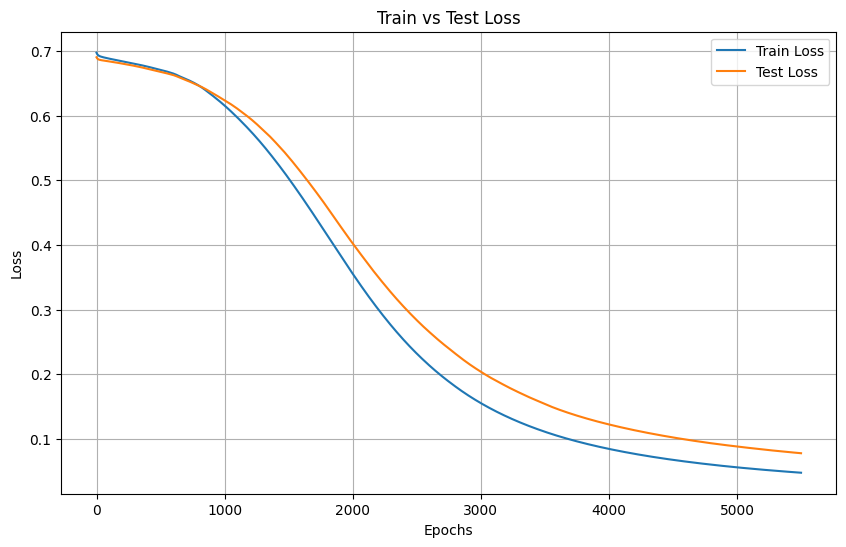

In [154]:
train_vs_test_loss(train_losses_gpu, test_losses_gpu)

In [155]:
for _ in range(5500):
    model0_cpu.train()
    y_logits = model0_cpu(X_train).squeeze()
    loss = loss_fn(y_logits, y_train)
    y_pred = torch.round(torch.sigmoid(y_logits))
    acc = accuracy_fn(y_train, y_pred)
    optimizer_cpu.zero_grad()
    loss.backward()
    optimizer_cpu.step()
    train_losses_cpu.append(loss.item())
    model0_cpu.eval()
    with torch.inference_mode():
        test_logits = model0_cpu(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    test_losses_cpu.append(test_loss.item())
    epochs_cpu += 1
    print(f"Epoch: {epochs_cpu} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    

Epoch: 1 | Loss: 0.69843, Acc: 50.00% | Test Loss: 0.69706, Test Acc: 50.00%
Epoch: 2 | Loss: 0.69800, Acc: 50.00% | Test Loss: 0.69669, Test Acc: 50.00%
Epoch: 3 | Loss: 0.69760, Acc: 50.00% | Test Loss: 0.69635, Test Acc: 50.00%
Epoch: 4 | Loss: 0.69723, Acc: 50.00% | Test Loss: 0.69604, Test Acc: 50.00%
Epoch: 5 | Loss: 0.69690, Acc: 50.00% | Test Loss: 0.69576, Test Acc: 50.00%
Epoch: 6 | Loss: 0.69658, Acc: 50.00% | Test Loss: 0.69549, Test Acc: 50.00%
Epoch: 7 | Loss: 0.69629, Acc: 50.00% | Test Loss: 0.69525, Test Acc: 50.00%
Epoch: 8 | Loss: 0.69603, Acc: 50.00% | Test Loss: 0.69503, Test Acc: 50.00%
Epoch: 9 | Loss: 0.69578, Acc: 50.00% | Test Loss: 0.69482, Test Acc: 50.00%
Epoch: 10 | Loss: 0.69555, Acc: 50.00% | Test Loss: 0.69463, Test Acc: 50.00%
Epoch: 11 | Loss: 0.69534, Acc: 50.00% | Test Loss: 0.69445, Test Acc: 50.00%
Epoch: 12 | Loss: 0.69514, Acc: 50.00% | Test Loss: 0.69429, Test Acc: 50.00%
Epoch: 13 | Loss: 0.69496, Acc: 50.00% | Test Loss: 0.69413, Test Acc: 50

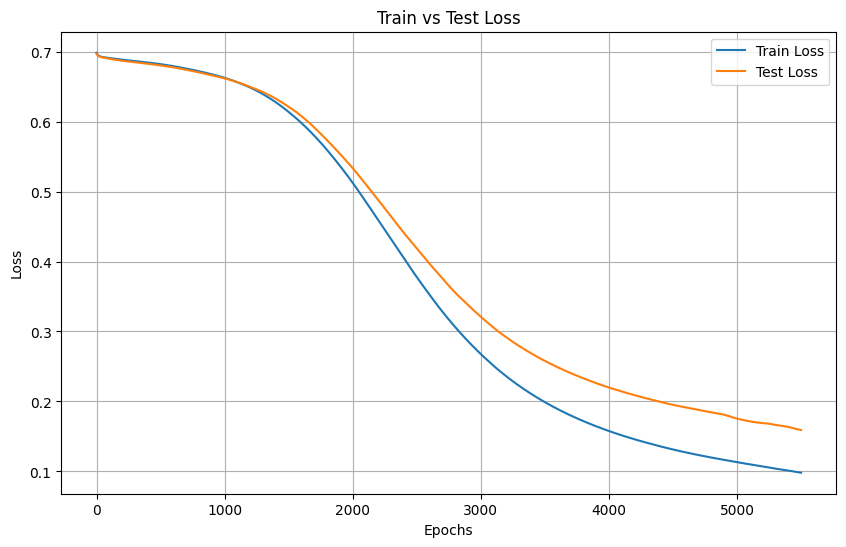

In [156]:
train_vs_test_loss(train_losses_cpu, test_losses_cpu)

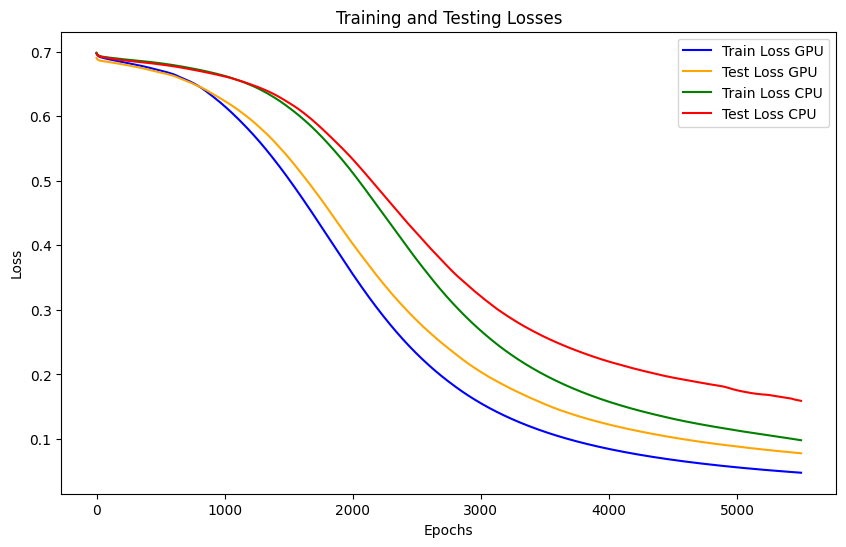

In [157]:
#compare two models performances
plt.figure(figsize=(10, 6))
plt.plot(range(epochs_gpu), train_losses_gpu, label='Train Loss GPU', color='blue')
plt.plot(range(epochs_gpu), test_losses_gpu, label='Test Loss GPU', color='orange')
plt.plot(range(epochs_cpu), train_losses_cpu, label='Train Loss CPU', color='green')
plt.plot(range(epochs_cpu), test_losses_cpu, label='Test Loss CPU', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()